In [1]:
"""
Election Simulation illustrating difference between bullet and full voting

Author: Washington Alto through the use of ChatGPT-4o
Date: May 2025

Features:
- Simulates two voting scenarios (Full and Bullet voting)
- Live visualization via animated matplotlib bar chart (console + GIF)
- Logs final vote tallies to CSV
- Logs per-ballot votes to CSV for full transparency
- Highlights favored candidates in both the chart and leaderboard
- Comparison bar chart showing top 12 results from both scenarios

Dependencies:
- matplotlib
- pandas

To run:
> pip install matplotlib pandas
> python election_simulation_final.py
"""

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import pandas as pd
import random
import os
from typing import List, Dict


class Ballot:
    """Represents a single voter's ballot."""

    def __init__(self, votes: List[str]):
        """
        Initialize a ballot with selected candidate votes.

        Args:
            votes (List[str]): Candidate names selected by the voter.
        """
        self.votes = votes


class Election:
    """Handles election setup, simulation, tallying, and visualization."""

    def __init__(self, candidates, max_votes_per_ballot, num_voters, favored_candidates):
        """
        Initialize election configuration.

        Args:
            candidates (List[str]): List of all candidate names.
            max_votes_per_ballot (int): Maximum number of candidates a voter can vote for.
            num_voters (int): Number of voters in the simulation.
            favored_candidates (List[str]): Candidates considered 'favored'.
        """
        self.candidates = candidates
        self.max_votes_per_ballot = max_votes_per_ballot
        self.num_voters = num_voters
        self.favored_candidates = favored_candidates
        self.ballots = []
        self.vote_tally = {c: 0 for c in candidates}
        self.bullet_votes = 0
        self.votes_log = []

    def generate_ballots(self, scenario, favored_percentage=0.1):
        """
        Generate voter ballots under a given scenario.

        Args:
            scenario (str): "full" for full ballots, "bullet" for partial/favored-only voting.
            favored_percentage (float): Portion of voters using bullet voting.
        """
        self.ballots.clear()
        self.votes_log.clear()
        self.vote_tally = {c: 0 for c in self.candidates}
        self.bullet_votes = 0
        for voter_id in range(1, self.num_voters + 1):
            if scenario == "bullet" and random.random() < favored_percentage:
                num_votes = random.randint(1, min(self.max_votes_per_ballot, len(self.favored_candidates)))
                votes = random.sample(self.favored_candidates, num_votes)
                self.bullet_votes += 1
            else:
                votes = random.sample(self.candidates, self.max_votes_per_ballot)
            self.ballots.append(Ballot(votes))
            self.votes_log.append({"Ballot": voter_id, "Votes": ", ".join(votes)})

    def run_election(self, output_gif_path, title_suffix, show_console=True):
        """
        Execute the election and generate visual outputs.
    
        Args:
            output_gif_path (str): Path to save the animated GIF file.
            title_suffix (str): Label used in titles and exported file names.
            show_console (bool): Whether to display animation in a live window.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        fig.suptitle(f"Election Simulation ({title_suffix})", fontsize=16, weight='bold')
    
        # Display favored candidates below the main title
        fav_text = f"Favored Candidates: {', '.join(self.favored_candidates)}"
        fig.text(0.5, 0.92, fav_text, ha='center', fontsize=12, color='crimson')
    
        bar_containers = {}
    
        def init():
            bars = ax1.bar(
                self.candidates,
                [0] * len(self.candidates),
                color=['crimson' if c in self.favored_candidates else 'steelblue' for c in self.candidates]
            )
            for bar, name in zip(bars, self.candidates):
                bar_containers[name] = bar
            ax1.set_ylim(0, self.num_voters)
            ax1.set_title('Vote Count per Candidate', fontsize=14)
            ax1.set_xlabel('Candidates (hidden)', fontsize=12)
            ax1.set_ylabel('Number of Votes', fontsize=12)
            ax1.set_xticks([])
    
            ax2.set_title('Live Leaderboard (Top 12 + 10)', fontsize=14, pad=30)  # Pad prevents overlap
            ax2.axis('off')
            return bars
    
        def update(frame):
            if frame < len(self.ballots):
                for candidate in self.ballots[frame].votes:
                    self.vote_tally[candidate] += 1
                for name, bar in bar_containers.items():
                    bar.set_height(self.vote_tally[name])
                sorted_votes = sorted(self.vote_tally.items(), key=lambda x: x[1], reverse=True)
    
                ax2.clear()
                ax2.axis('off')
                ax2.set_title('Live Leaderboard (Top 12 + 10)', fontsize=14, pad=30)
                for i, (name, count) in enumerate(sorted_votes[:self.max_votes_per_ballot + 10]):
                    color = 'crimson' if name in self.favored_candidates else 'steelblue'
                    label = f"{i+1:>2}. {name}: {count} vote{'s' if count != 1 else ''}"
                    if i < self.max_votes_per_ballot:
                        label += "  <-- WINNER"
                    ax2.text(0.01, 0.95 - i * 0.045, label, fontsize=12, color=color, fontfamily='monospace', transform=ax2.transAxes)
    
                if (frame + 1) % 10 == 0 or frame + 1 == len(self.ballots):
                    print(f"[{title_suffix}] Processed {frame + 1}/{len(self.ballots)} ballots...", end='\r')
    
            return list(bar_containers.values())
    
        ani = animation.FuncAnimation(fig, update, frames=len(self.ballots), init_func=init,
                                      blit=False, repeat=False)
        ani.save(output_gif_path, writer=PillowWriter(fps=10))
        print(f"\n[{title_suffix}] Animation saved to {output_gif_path}")
    
        if show_console:
            plt.show()
    
        plt.close()
        return self.export_results(title_suffix)

    def export_results(self, title_suffix):
        """
        Export vote summary and raw ballots to CSV.

        Args:
            title_suffix (str): Scenario label used in filenames.
        """
        sorted_results = sorted(self.vote_tally.items(), key=lambda x: x[1], reverse=True)
        df = pd.DataFrame(sorted_results, columns=["Candidate", "Votes"])
        output_csv = f"election_result_{title_suffix.lower().replace(' ', '_')}.csv"
        df.to_csv(output_csv, index=False)

        df_log = pd.DataFrame(self.votes_log)
        output_log = f"election_votes_log_{title_suffix.lower().replace(' ', '_')}.csv"
        df_log.to_csv(output_log, index=False)

        print(f"[{title_suffix}] Final results saved to: {output_csv}")
        print(f"[{title_suffix}] Ballot logs saved to: {output_log}")
        return df


def plot_comparison(df_full, df_bullet, top_n=12):
    """
    Generate a comparison bar chart for top N candidates.

    Args:
        df_full (DataFrame): Results from full voting scenario.
        df_bullet (DataFrame): Results from bullet voting scenario.
        top_n (int): Number of candidates to include in the comparison.
    """
    merged = pd.merge(
        df_full.head(top_n).rename(columns={"Votes": "Full Voting"}),
        df_bullet.head(top_n).rename(columns={"Votes": "Bullet Voting"}),
        on="Candidate", how="outer"
    ).fillna(0)

    merged.set_index("Candidate")[["Full Voting", "Bullet Voting"]].plot(kind="bar", figsize=(12, 6))
    plt.title("Top 12 Candidates: Full Voting vs Bullet Voting")
    plt.ylabel("Votes")
    plt.tight_layout()
    plt.savefig("comparison_top12_bar_chart.png")
    plt.show()


def main():
    """
    Run the complete election simulation workflow:
    - Full voting
    - Bullet voting
    - CSV outputs
    - Animated GIFs
    - Comparison plot
    """
    C = 66
    M = 12
    N = 100
    candidates = [f"c{i + 1}" for i in range(C)]
    favored_candidates = ["c51", "c45", "c5"]

    # Full Voting Simulation
    full = Election(candidates, M, N, favored_candidates)
    full.generate_ballots("full")
    df_full = full.run_election("election_full_voting.gif", "Full Voting", show_console=True)

    # Bullet Voting Simulation
    bullet = Election(candidates, M, N, favored_candidates)
    bullet.generate_ballots("bullet", favored_percentage=0.25)
    df_bullet = bullet.run_election("election_bullet_voting.gif", "Bullet Voting", show_console=True)

    # Comparison Chart
    plot_comparison(df_full, df_bullet)




[Full Voting] Processed 100/100 ballots...
[Full Voting] Animation saved to election_full_voting.gif


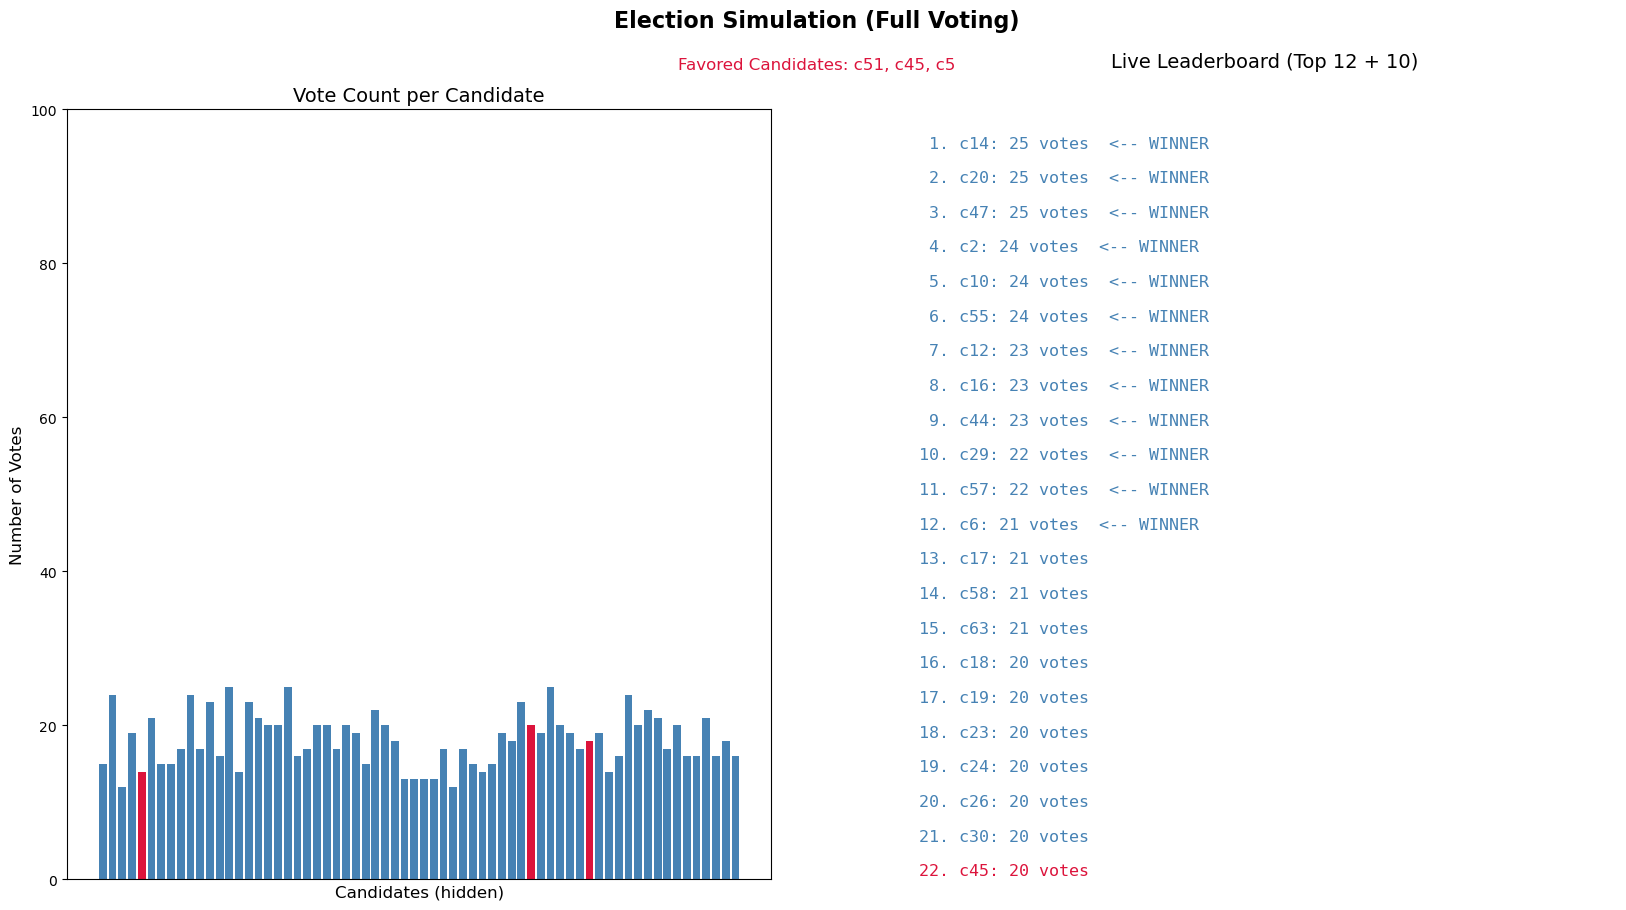

[Full Voting] Final results saved to: election_result_full_voting.csv
[Full Voting] Ballot logs saved to: election_votes_log_full_voting.csv
[Bullet Voting] Processed 100/100 ballots...
[Bullet Voting] Animation saved to election_bullet_voting.gif


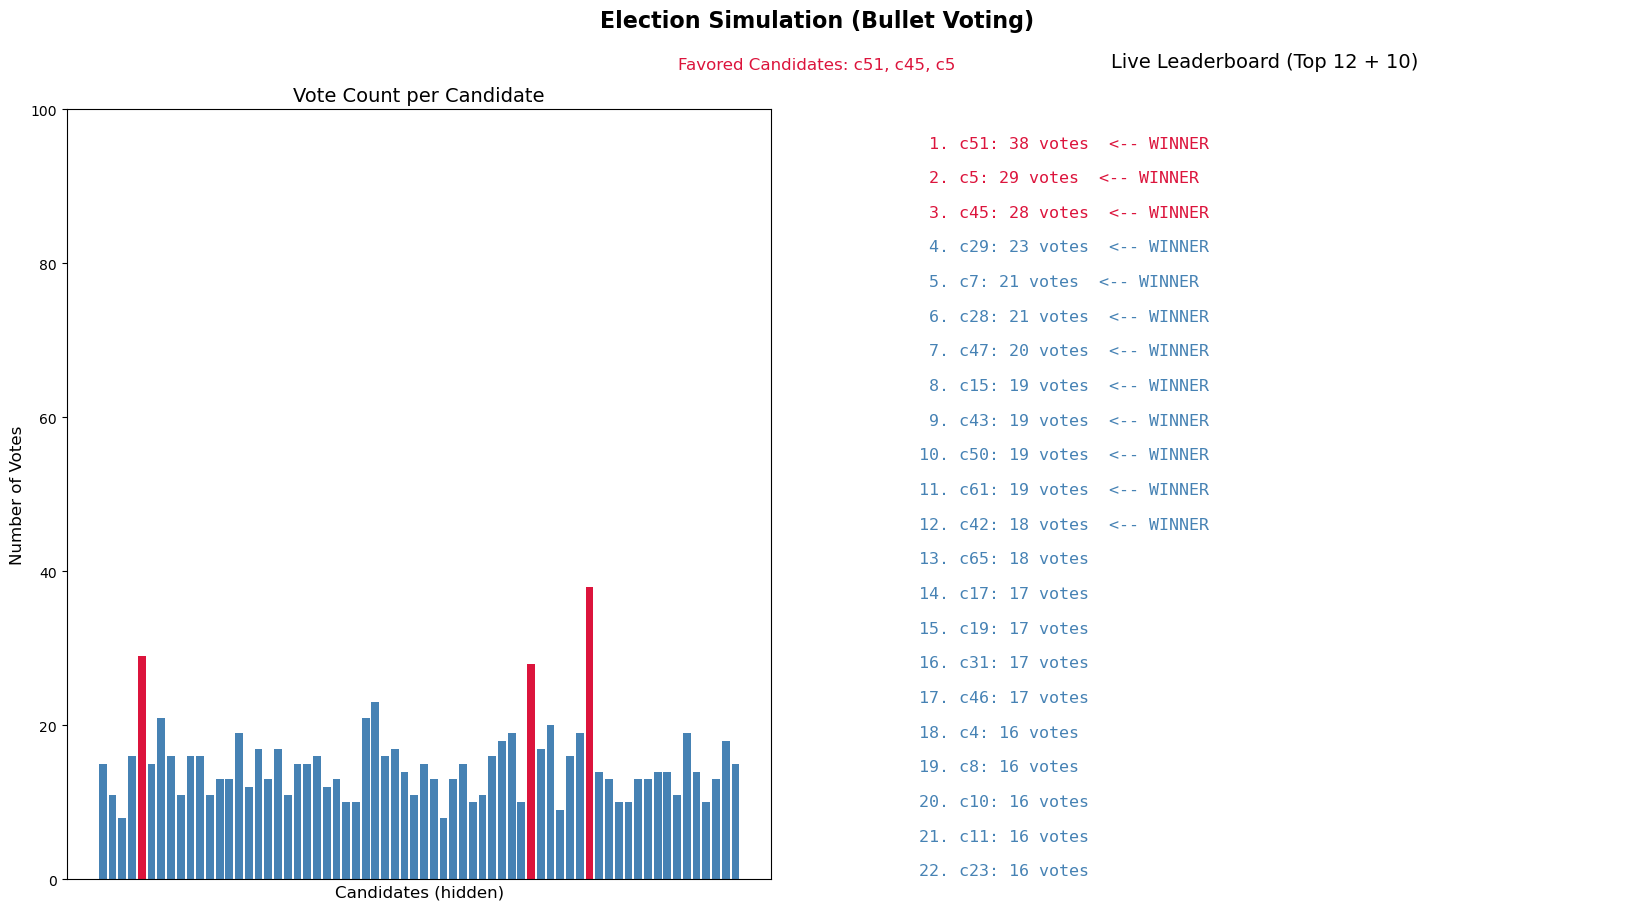

[Bullet Voting] Final results saved to: election_result_bullet_voting.csv
[Bullet Voting] Ballot logs saved to: election_votes_log_bullet_voting.csv


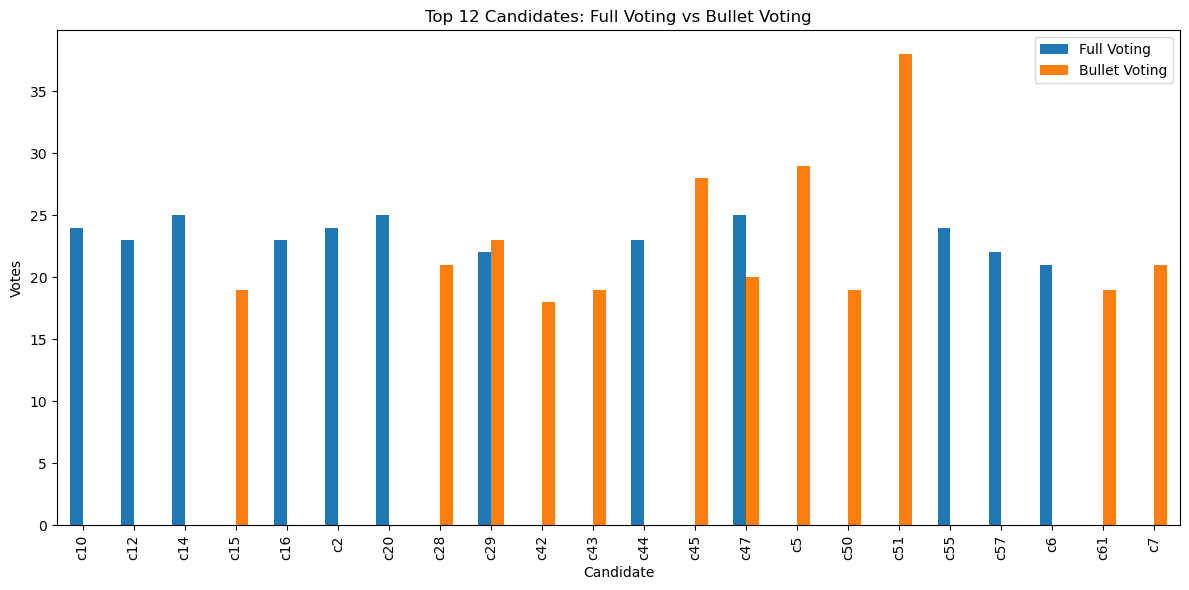

In [2]:
if __name__ == "__main__":
    main()